In [1]:
import numpy as np
import arviz as az
import pymc as pm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pytensor.tensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def standardize(series):
    return (series - series.mean()) / series.std()

### Data Import and Pre-Processing

In [107]:
df = pd.read_csv("realtor-data.csv")
df

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2226377,23009.0,sold,359900.0,4.0,2.0,0.33,353094.0,Richland,Washington,99354.0,3600.0,2022-03-25
2226378,18208.0,sold,350000.0,3.0,2.0,0.10,1062149.0,Richland,Washington,99354.0,1616.0,2022-03-25
2226379,76856.0,sold,440000.0,6.0,3.0,0.50,405677.0,Richland,Washington,99354.0,3200.0,2022-03-24
2226380,53618.0,sold,179900.0,2.0,1.0,0.09,761379.0,Richland,Washington,99354.0,933.0,2022-03-24


In [108]:
filtered_df = df[['price', 'city', 'house_size']]
filtered_df = filtered_df.dropna()

# Nnumber of Cities to Confound On
n_cities = 10
top_cities = filtered_df['city'].value_counts().head(n_cities).reset_index()
print(top_cities)
top_cities = top_cities['city']

filtered_df = filtered_df[filtered_df['city'].isin(top_cities)]
filtered_df = filtered_df[filtered_df['house_size'] != 1560780.0]

print(filtered_df) # -> Final Data

            city  count
0        Houston  21700
1        Chicago  12081
2   Jacksonville  10856
3   Philadelphia   9587
4          Miami   9097
5    Los Angeles   8372
6         Tucson   8350
7  New York City   8179
8        Phoenix   7873
9         Dallas   7832
              price           city  house_size
45719     3600000.0  New York City      2338.0
45720    22000000.0  New York City      7020.0
45736     1250000.0  New York City       568.0
45738      395000.0  New York City       650.0
45740     8625000.0  New York City      2617.0
...             ...            ...         ...
2188864     92500.0         Dallas      1082.0
2188884    349900.0         Dallas      1472.0
2188887    420000.0         Dallas      1413.0
2188888    445504.0         Dallas      1440.0
2188907    380000.0         Dallas      1382.0

[103926 rows x 3 columns]


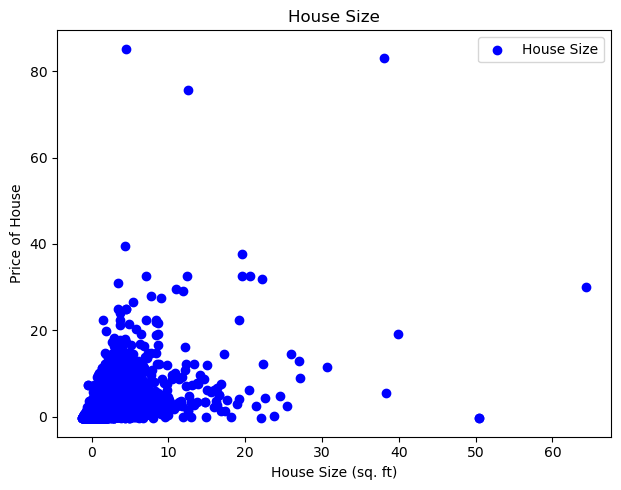

In [109]:
house_size_standardized = standardize(filtered_df['house_size'])
price_standardized = standardize(filtered_df['price'])
city = pd.Categorical(filtered_df['city']).codes

plt.figure(figsize=(12, 5))

# Scatter plot for house_size
plt.subplot(1, 2, 1)
plt.scatter(house_size_standardized, price_standardized, color='blue', label='House Size')
plt.title('House Size')
plt.xlabel('House Size (sq. ft)')
plt.ylabel('Price of House')
plt.legend()
# Display the plots
plt.tight_layout()
plt.show()



### Prior Predective Simulation

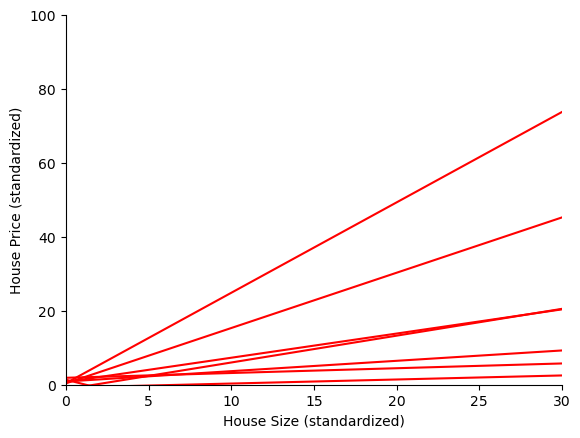

In [126]:
# prior predictive simulation
n = 10
a = stats.norm.rvs(0, 1, size=n)
b_a = stats.norm.rvs(0, 1, size=n)
house_price_seq = np.linspace(0, 60, 40)

for i in range(n):
    mu = a[i] + b_a[i] * house_price_seq
    plt.plot(house_price_seq, mu, color='r')
 
plt.xlim((0, 30))
plt.ylim((0, 100))
plt.xlabel("House Size (standardized)")
plt.ylabel("House Price (standardized)")
sns.despine()

### Model Testing on Simulated Data

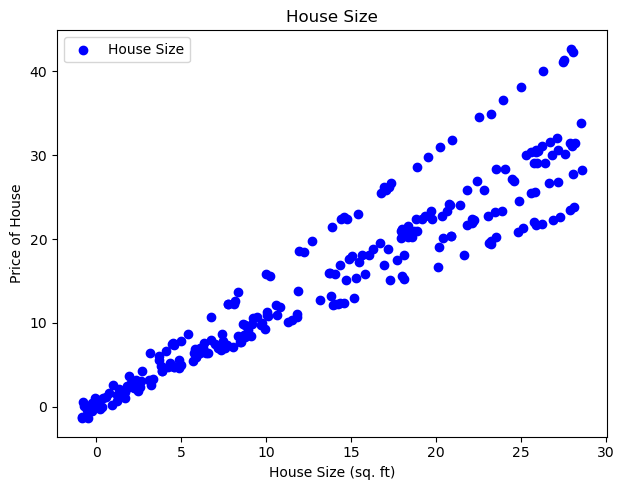

In [101]:
np.random.seed(42)

simulated_n_cities = 5  # Number of unique cities
n_samples_per_city = 50  # Number of data points per city
n_total = simulated_n_cities * n_samples_per_city

# Pre-defined parameters
true_alpha = np.array([0.5, -0.2, 1.0, -0.5, 0.3])  # True intercepts for each city
true_beta = np.array([1.5, 1.0, 0.8, 1.2, 1.1])     # True slopes for each city
true_sigma = 0.3

# Generate synthetic data
simulated_cities = np.repeat(np.arange(simulated_n_cities), n_samples_per_city)
simulated_house_size = stats.uniform.rvs(-1, 30, n_total)
simulated_price_standardized = (
    true_alpha[simulated_cities] +
    true_beta[simulated_cities] * simulated_house_size +
    np.random.normal(0, true_sigma, size=n_total)
)

# Create a DataFrame for easier manipulation
simulated_data = pd.DataFrame({
    'city': simulated_cities,
    'simulated_house_size': simulated_house_size,
    'simulated_price_standardized': simulated_price_standardized
})

plt.figure(figsize=(12, 5))

# Scatter plot for house_size
plt.subplot(1, 2, 1)
plt.scatter(simulated_data['simulated_house_size'], simulated_data['simulated_price_standardized'], color='blue', label='House Size')
plt.title('House Size')
plt.xlabel('House Size (sq. ft)')
plt.ylabel('Price of House')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [70]:
# PyMC model for simulated data
with pm.Model() as simulated_model:

    alpha = pm.Normal('alpha', mu=0, sigma=1, shape=simulated_n_cities)
    beta = pm.Normal('beta', mu=0, sigma=0.75, shape=simulated_n_cities)
    sigma = pm.Exponential('sigma', 1)
    
    # Linear model
    mu = alpha[simulated_data['city']] + beta[simulated_data['city']] * simulated_data['simulated_house_size']
    
    # Likelihood
    pred = pm.Normal('p', mu=mu, sigma=sigma, observed=simulated_data['simulated_price_standardized'])
    
    # Inference
    simulated_idata= pm.sample(idata_kwargs={"log_likelihood": True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [75]:
az.summary(simulated_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.672,0.078,0.522,0.817,0.001,0.001,4787.0,2774.0,1.0
alpha[1],-0.202,0.080,-0.353,-0.054,0.001,0.001,5269.0,2922.0,1.0
alpha[2],1.089,0.078,0.933,1.227,0.001,0.001,4720.0,2780.0,1.0
alpha[3],-0.532,0.085,-0.679,-0.360,0.001,0.001,4190.0,2414.0,1.0
alpha[4],0.326,0.080,0.175,0.478,0.001,0.001,4476.0,2921.0,1.0
beta[0],1.494,0.002,1.490,1.499,0.000,0.000,4619.0,2590.0,1.0
beta[1],1.000,0.002,0.996,1.004,0.000,0.000,5166.0,2645.0,1.0
beta[2],0.799,0.002,0.795,0.803,0.000,0.000,4618.0,2732.0,1.0
beta[3],1.201,0.002,1.197,1.206,0.000,0.000,4240.0,2604.0,1.0
beta[4],1.100,0.002,1.096,1.104,0.000,0.000,4955.0,2798.0,1.0


In [76]:
posterior_alpha = simulated_idata.posterior['alpha'].mean(dim=("chain", "draw"))
posterior_beta = simulated_idata.posterior['beta'].mean(dim=("chain", "draw"))
posterior_sigma = simulated_idata.posterior['sigma'].mean(dim=("chain", "draw"))

for i in range(simulated_n_cities):
    print(f"City {i}: True alpha = {true_alpha[i]:.2f}, Estimated alpha = {posterior_alpha[i].values:.2f}")
    print(f"City {i}: True beta = {true_beta[i]:.2f}, Estimated beta = {posterior_beta[i].values:.2f}")
print(f"True sigma = {true_sigma:.2f}, Estimated sigma = {posterior_sigma.values:.2f}")

City 0: True alpha = 0.50, Estimated alpha = 0.67
City 0: True beta = 1.50, Estimated beta = 1.49
City 1: True alpha = -0.20, Estimated alpha = -0.20
City 1: True beta = 1.00, Estimated beta = 1.00
City 2: True alpha = 1.00, Estimated alpha = 1.09
City 2: True beta = 0.80, Estimated beta = 0.80
City 3: True alpha = -0.50, Estimated alpha = -0.53
City 3: True beta = 1.20, Estimated beta = 1.20
City 4: True alpha = 0.30, Estimated alpha = 0.33
City 4: True beta = 1.10, Estimated beta = 1.10
True sigma = 0.30, Estimated sigma = 0.30


### Posterior Model

In [110]:
with pm.Model() as model:
    a = pm.Normal('a', mu = 0, sigma = 1, shape = n_cities)
    b = pm.LogNormal('b', mu = 0, sigma = 1, shape = n_cities)
    sigma = pm.Exponential('sigma', 1)
    mu = a[city] + b[city] * house_size_standardized
    pred_price = pm.Normal('p', mu = mu, sigma = sigma, observed = price_standardized)

    idata = pm.sample(idata_kwargs={"log_likelihood": True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.


In [111]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.098,0.007,-0.110,-0.085,0.0,0.0,9391.0,2852.0,1.0
a[1],-0.148,0.008,-0.163,-0.132,0.0,0.0,9044.0,3031.0,1.0
a[2],-0.215,0.005,-0.225,-0.207,0.0,0.0,8466.0,3041.0,1.0
a[3],-0.214,0.007,-0.227,-0.200,0.0,0.0,8670.0,3191.0,1.0
a[4],0.274,0.008,0.259,0.289,0.0,0.0,9753.0,2888.0,1.0
a[5],0.209,0.008,0.193,0.223,0.0,0.0,9179.0,3203.0,1.0
a[6],1.114,0.008,1.099,1.128,0.0,0.0,10521.0,3460.0,1.0
a[7],-0.170,0.008,-0.184,-0.155,0.0,0.0,9863.0,3115.0,1.0
a[8],-0.104,0.008,-0.120,-0.088,0.0,0.0,9060.0,3156.0,1.0
a[9],-0.184,0.008,-0.200,-0.170,0.0,0.0,9036.0,3517.0,1.0


array([[<Axes: title={'center': 'a\n0'}>,
        <Axes: title={'center': 'a\n0'}>],
       [<Axes: title={'center': 'a\n1'}>,
        <Axes: title={'center': 'a\n1'}>],
       [<Axes: title={'center': 'a\n2'}>,
        <Axes: title={'center': 'a\n2'}>],
       [<Axes: title={'center': 'a\n3'}>,
        <Axes: title={'center': 'a\n3'}>],
       [<Axes: title={'center': 'a\n4'}>,
        <Axes: title={'center': 'a\n4'}>],
       [<Axes: title={'center': 'a\n5'}>,
        <Axes: title={'center': 'a\n5'}>],
       [<Axes: title={'center': 'a\n6'}>,
        <Axes: title={'center': 'a\n6'}>],
       [<Axes: title={'center': 'a\n7'}>,
        <Axes: title={'center': 'a\n7'}>],
       [<Axes: title={'center': 'a\n8'}>,
        <Axes: title={'center': 'a\n8'}>],
       [<Axes: title={'center': 'a\n9'}>,
        <Axes: title={'center': 'a\n9'}>]], dtype=object)

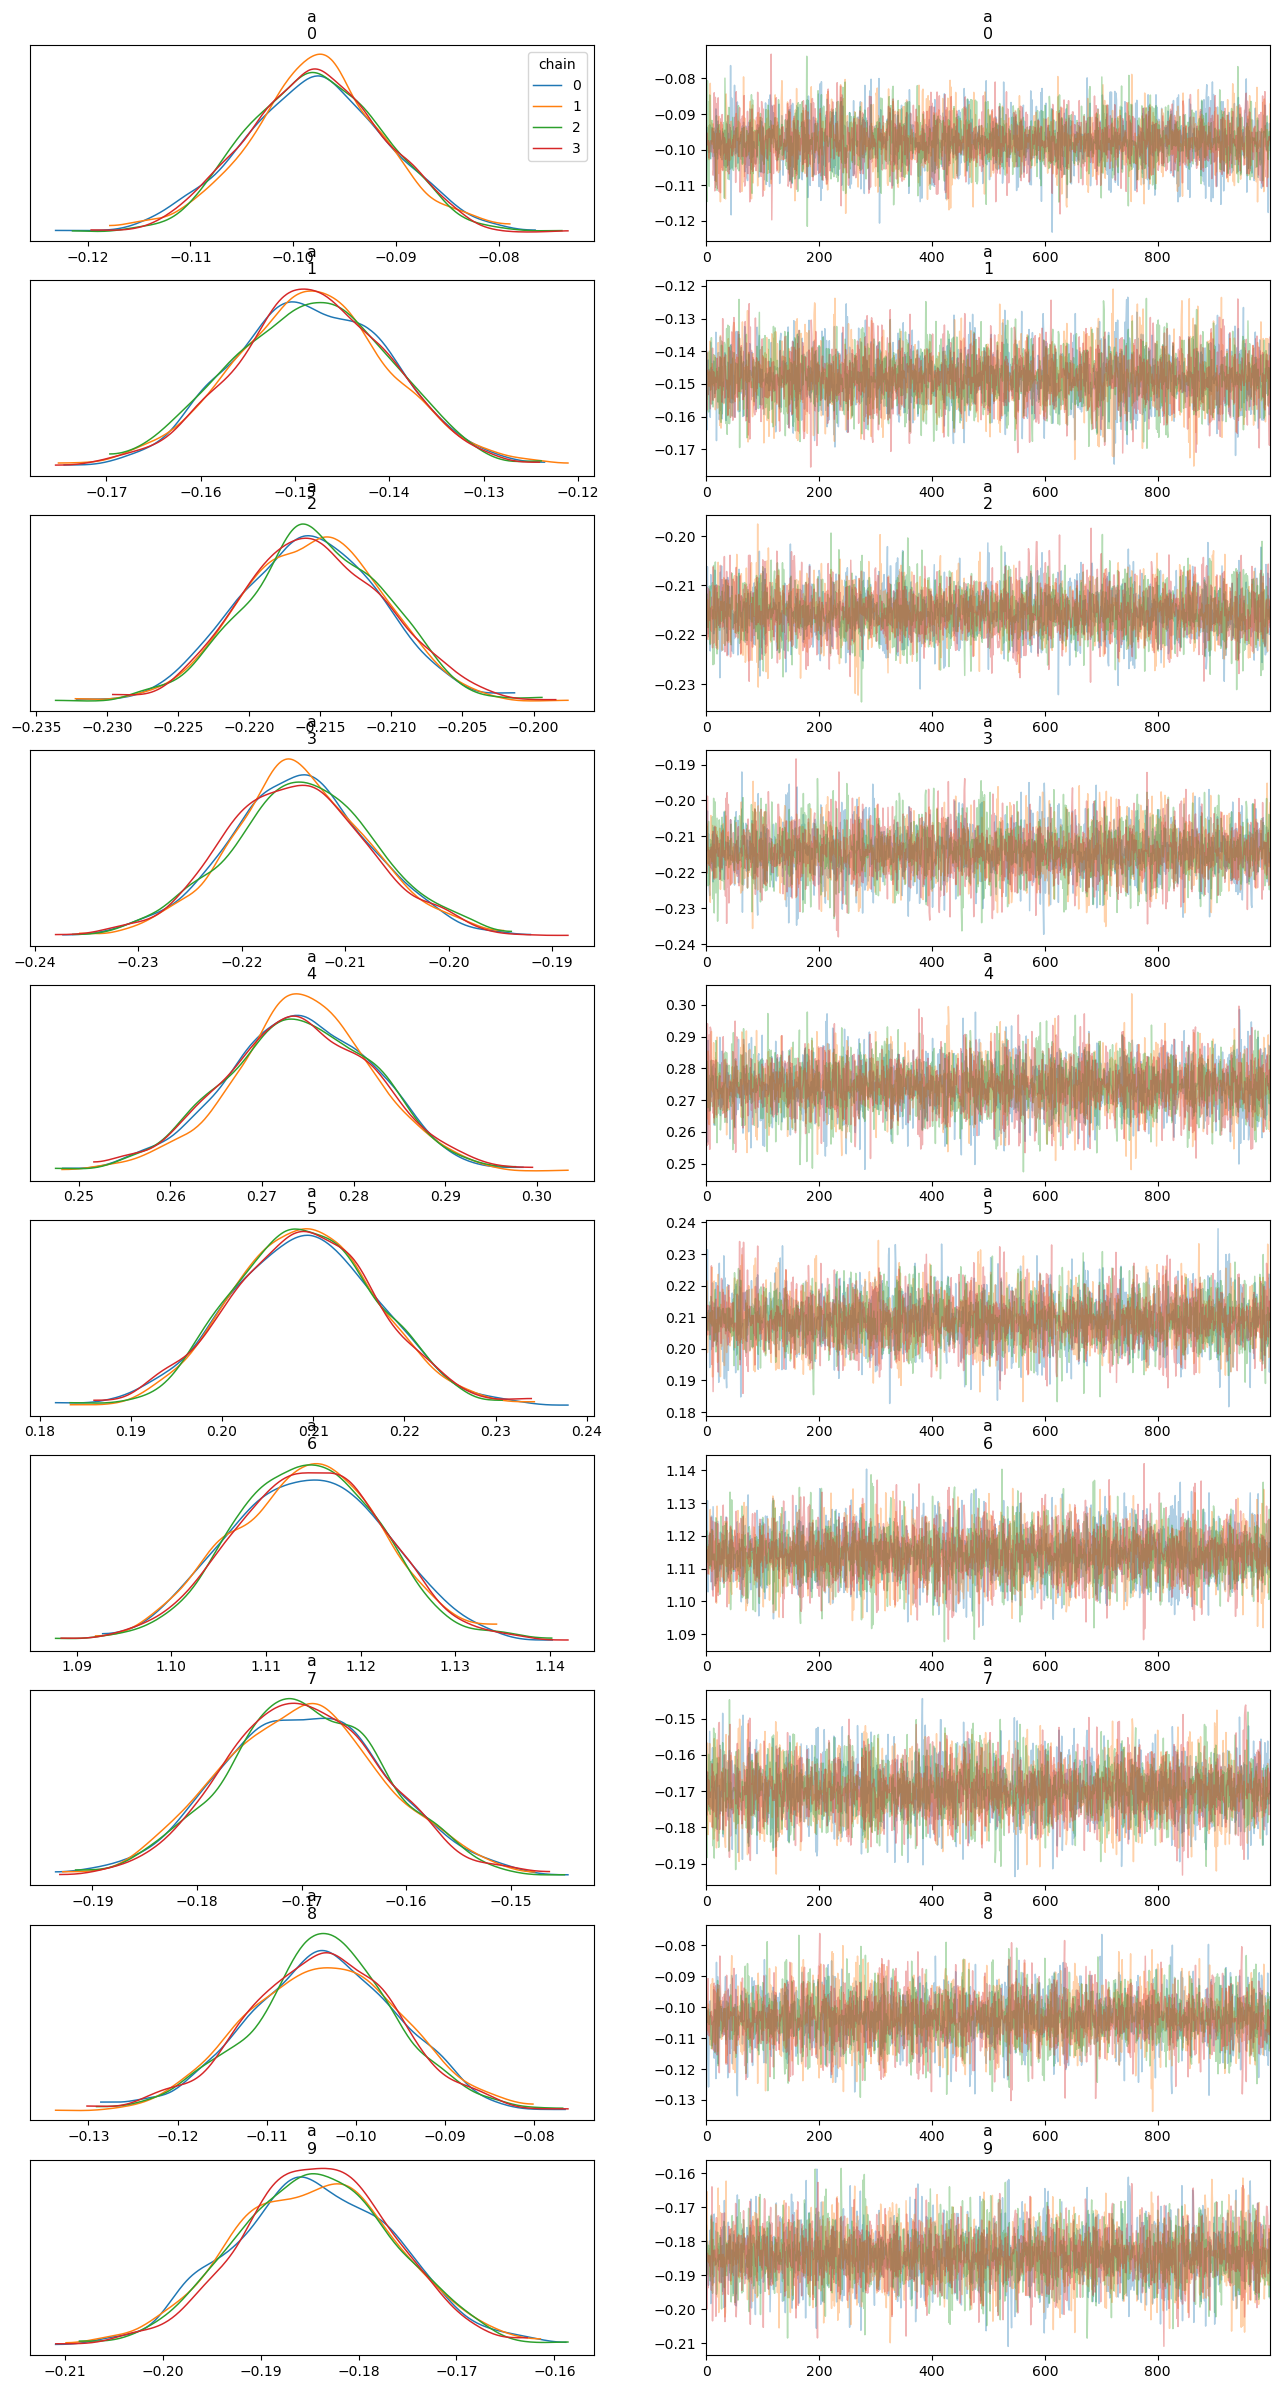

In [116]:
az.plot_trace(idata, var_names=["a"], legend=True, figsize=(16,30), compact=False)

array([[<Axes: title={'center': 'a\n0'}>,
        <Axes: title={'center': 'a\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'a\n1'}>,
        <Axes: title={'center': 'a\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'a\n2'}>,
        <Axes: title={'center': 'a\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'a\n3'}>,
        <Axes: title={'center': 'a\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'a\n4'}>,
        <Axes: title={'center': 'a\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'a\n5'}>,
        <Axes: title={'center': 'a\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'a\n6'}>,
        <Axes: title={'center': 'a\n6'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'a\n7'}>,
        <Axes: title={'center': 'a\n7'}, xlabel='Rank (

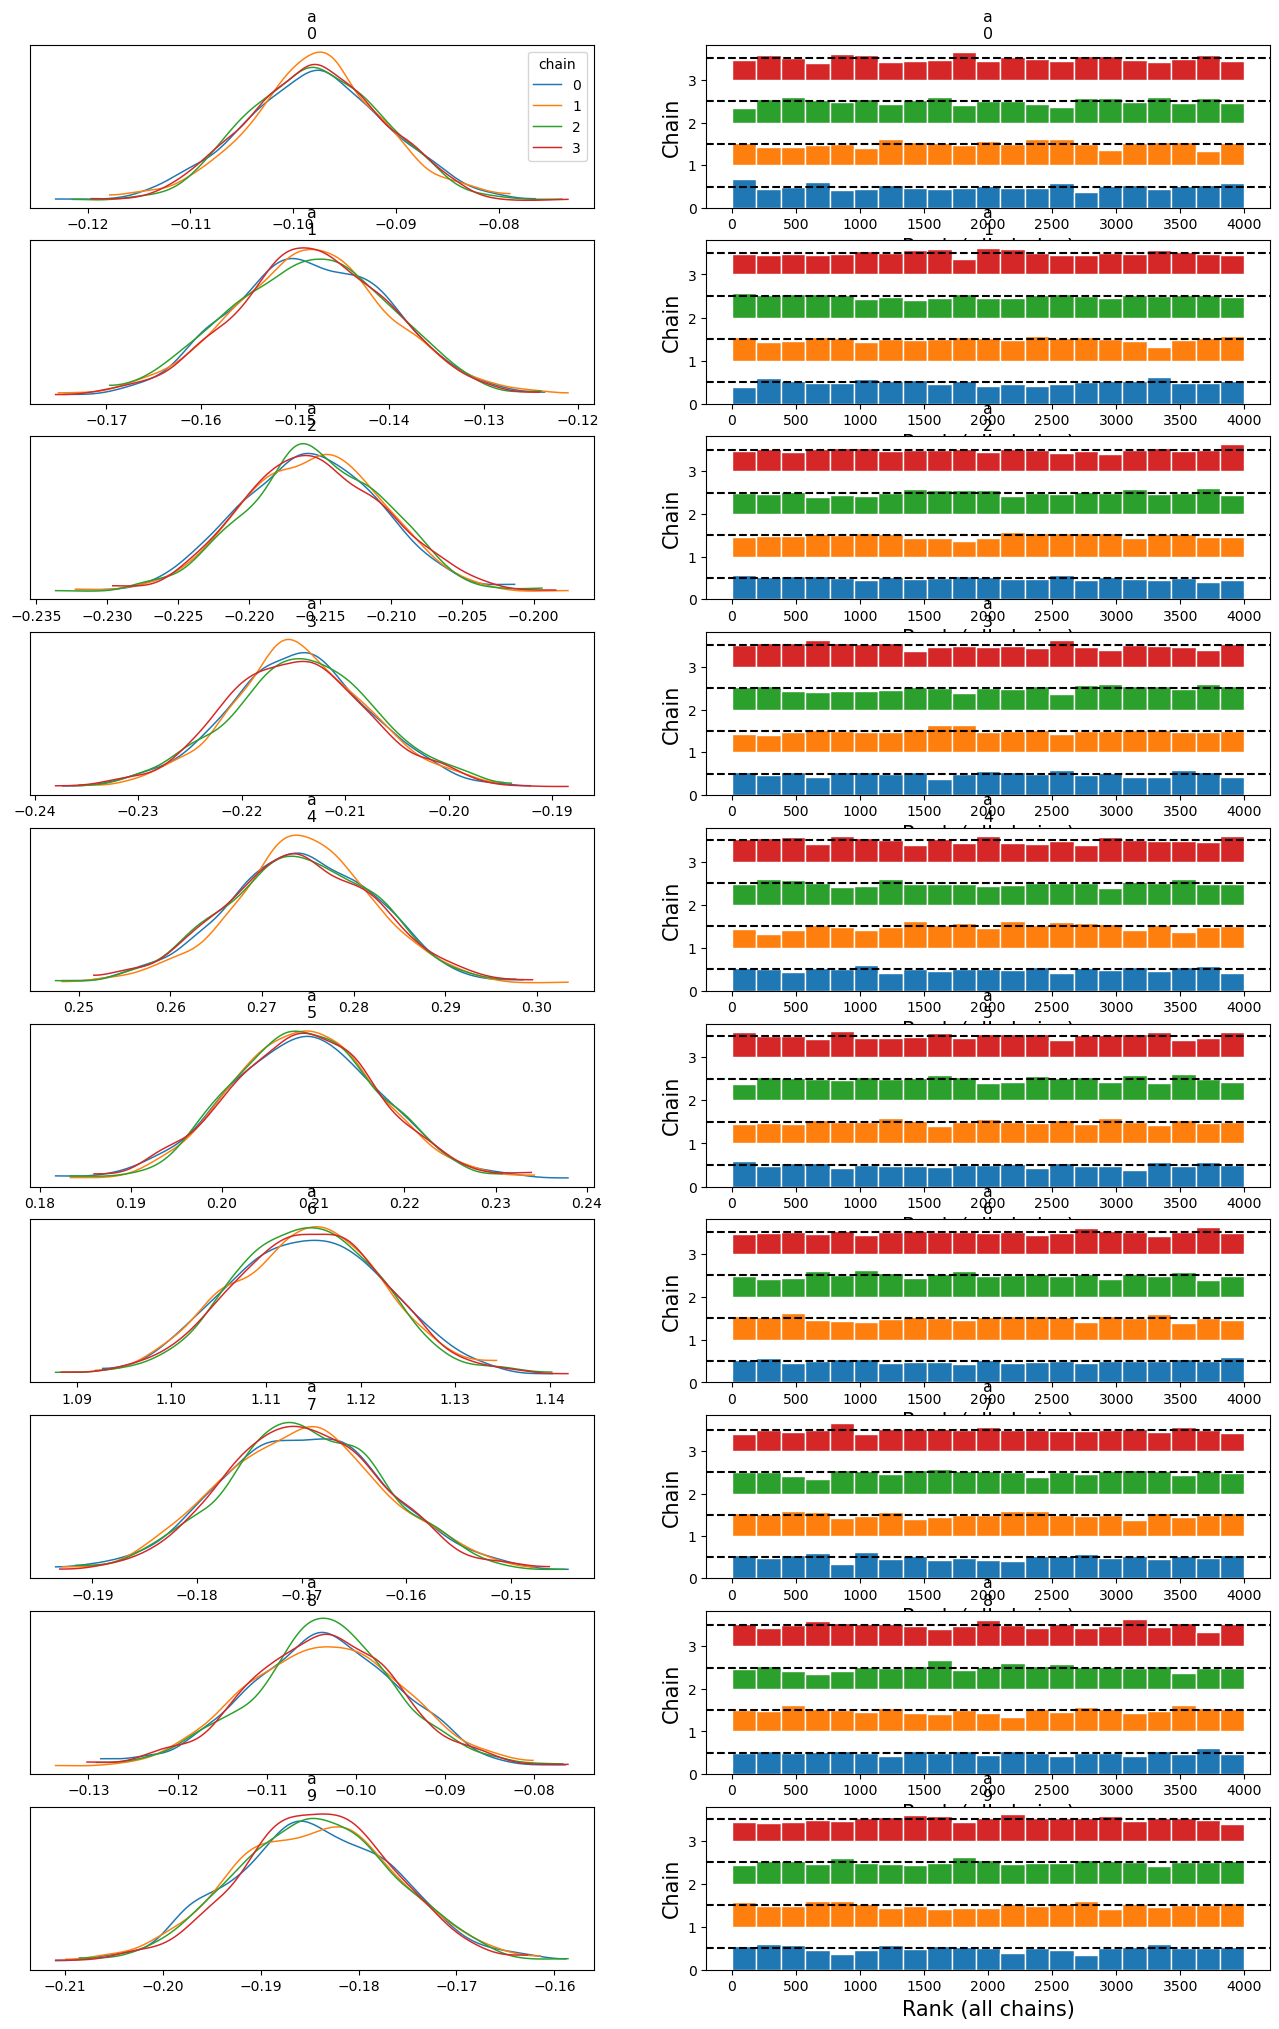

In [120]:
az.plot_trace(idata, var_names=["a"], legend=True, compact=False, kind="rank_bars", figsize=(16,25))